In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import vartools as vt

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display

## Obtención de datos

In [2]:
tickers = ['AAPL', 'WMT', 'JPM', 'PG', 'META', 'V']
benchmark = '^GSPC'

price = yf.download(tickers, start='2021-01-01', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', progress=False)['Close']

rt = price.pct_change().dropna()
rt_benchmark = benchmark_data.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


In [3]:
print(f'Precios de los activos')
display(price.head())
print()

print(f'Volumen de los activos')
display(volume.head());

Precios de los activos


Ticker,AAPL,WMT,JPM,PG,META,V
Date,,,,,,
2021-01-04,126.4052,46.0713,112.3085,124.0700,267.9166,211.1414
2021-01-05,127.9681,45.8261,112.9196,124.8622,269.9389,207.9902
2021-01-06,123.6605,46.1122,118.2218,126.1766,262.3080,206.1576
2021-01-07,127.8801,46.1091,122.1041,124.9973,267.7173,207.3115
2021-01-08,128.9839,46.1028,122.2390,124.9432,266.5518,208.9016



Volumen de los activos


Ticker,AAPL,WMT,JPM,PG,META,V
Date,,,,,,
2021-01-04,143301900,32182200,16819900,8330900,15106100,10318300
2021-01-05,97664900,26498100,13731200,6856400,9871600,6869700
2021-01-06,155088000,21918900,24909100,10578000,24354100,7206200
2021-01-07,109578200,20538000,21940400,7355400,15789800,10967900
2021-01-08,105158200,24478200,12035100,7448500,18528300,6513000


In [4]:
pd.set_option('display.float_format', '{:.2%}'.format)
stats_df = pd.DataFrame({
    'Rendimiento Anual': rt.mean() * 252,
    'Volatilidad Anual': rt.std() * np.sqrt(252),
})
stats_df.T

Ticker,AAPL,WMT,JPM,PG,META,V
Rendimiento Anual,16.96%,17.44%,20.03%,9.45%,29.47%,13.41%
Volatilidad Anual,26.74%,20.19%,24.16%,17.05%,44.15%,22.53%


## Optimización y Evolución de Portafolios

### Funciones de Optimización

In [5]:
def opt_sharpe(returns: pd.DataFrame, rf: float) -> np.ndarray:
    """
    Optimiza los pesos de un portafolio para maximizar el Sharpe Ratio.

    Parámetros:
    -----------
    returns : DataFrame
        Un DataFrame de pandas que contiene los rendimientos históricos diarios de los activos.
    rf : float
        Tasa libre de riesgo anualizada.

    Retorna:
    --------
    w_opt_sharpe : ndarray
        Un array con los pesos óptimos de los activos en el portafolio que maximizan el Sharpe Ratio.
    """

    # Cálculos
    mu = (returns.mean() * 252).values
    sigma = returns.cov().values
    n_assets = len(mu)

    # Función para minimizar (-Sharpe Ratio)
    def neg_sharpe_ratio(w, mu, sigma, rf):
        port_return = np.dot(w, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)
        sharpe_ratio = (port_return - rf) / port_vol
        return -sharpe_ratio
    
    # Restricciones: Suma de pesos = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1
    })

    # Límites: Pesos entre 0 y 1 (no posiciones cortas)
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Pesos iniciales (distribuidos uniformemente)
    w0 = np.array([1 / n_assets] * n_assets)

    # Optimización
    result = minimize(neg_sharpe_ratio, 
            w0, 
            args=(mu, sigma, rf), 
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints)
    
    # Resultados
    w_opt_sharpe = result.x

    return w_opt_sharpe

In [6]:
pd.reset_option('display.float_format')

rf = 0.05
start_date = '2022-01-01'
end_date = '2023-12-31'
price_train = price.loc[start_date:end_date]

rt_train = price_train.pct_change().dropna()

### Máximo Ratio de Sharpe

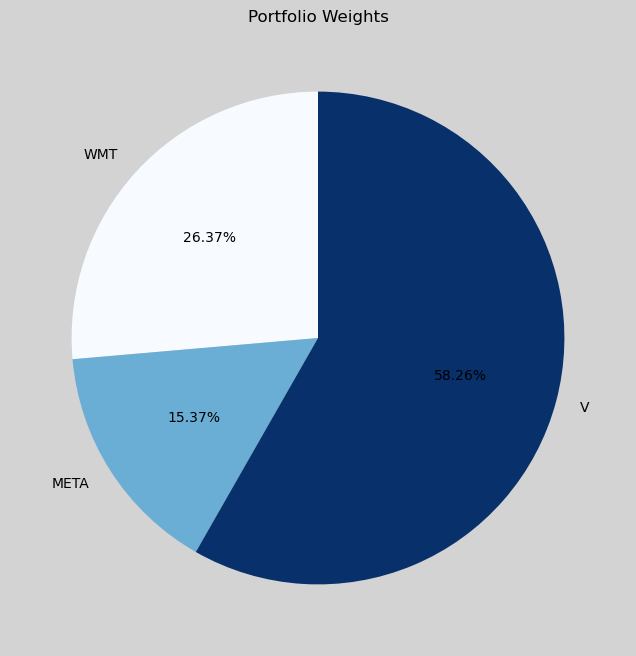

In [7]:
w_sharpe = opt_sharpe(rt_train, rf)
vt.plot_weights(tickers, w_sharpe)